In [2]:
import os
import json
from tqdm import tqdm
# import openai
# from openai import OpenAI
from typing import List
from rank_bm25 import BM25Okapi
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import numpy as np
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sliver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = 'data/aihub_rules_prev.json'
with open(data, 'r', encoding="UTF-8") as j:
    aihub_rule = json.load(j)
    
normal_rule = aihub_rule['normal']
abnormal_rule = aihub_rule['abnormal']
combined_rules = normal_rule + abnormal_rule

In [4]:
root_path = '/data1/sliver/jwsuh/construction_dataset/aihub/llava/llava_image_result_with_obj'

files = os.listdir(root_path)
files = [i for i in files if i.endswith('.json')]
files = sorted(files)

### BM25

In [4]:
def tokenize(text):
    return word_tokenize(text.lower())

def find_answer_rank(top_k_indices, answer_index):
    """
    top_k_indices: 상위 문서들의 인덱스가 담긴 배열
    answer_index: 찾고자 하는 정답 문서의 인덱스
    반환값: 정답 문서의 순위 (1부터 시작), 목록에 없는 경우 -1 반환
    """
    # top_k_indices에서 정답 인덱스를 찾아 순위를 반환
    try:
        rank = (top_k_indices == answer_index).nonzero()[0][0] + 1
        return rank
    except IndexError:
        # 정답 인덱스가 배열에 없는 경우
        return -1

In [12]:
# BM25+rerank

# 규칙 문장들 토큰화
def tokenize(text):
    return word_tokenize(text.lower())

tokenized_rules = [tokenize(rule) for rule in combined_rules]

# BM25 모델 생성
bm25 = BM25Okapi(tokenized_rules)


def find_answer_rank(top_k_indices, answer_index):
    """
    top_k_indices: 상위 문서들의 인덱스가 담긴 배열
    answer_index: 찾고자 하는 정답 문서의 인덱스
    반환값: 정답 문서의 순위 (1부터 시작), 목록에 없는 경우 -1 반환
    """
    try:
        rank = top_k_indices.index(answer_index) + 1
        return rank
    except ValueError:
        return -1
    

list_k = [1,5,10,15,20,25,30]
bm25_rerank_save_right_index = {}
bm25_rerank_save_wrong_index = {}
for top_k in list_k:
    correct = 0
    bm25_rerank_save_right_index[top_k] = {}
    bm25_rerank_save_wrong_index[top_k] = {}
    ind = 0
    for file in tqdm(files):
            
        with open(os.path.join(root_path, file), 'r', encoding="UTF-8") as j:
            caption = json.load(j)

        query = tokenize(caption['outputs'])

        initial_top_k = 50  # 초기 상위 50개 결과를 추출

        # BM25 초기 검색
        initial_scores = bm25.get_scores(query)
        initial_indices = initial_scores.argsort()[-initial_top_k:][::-1]  # 점수가 높은 순서로 인덱스 정렬

        # 초기 상위 50개 결과를 사용하여 새로운 BM25 모델 생성
        re_ranked_rules = [combined_rules[i] for i in initial_indices]
        tokenized_re_ranked_rules = [tokenize(rule) for rule in re_ranked_rules]
        re_ranked_bm25 = BM25Okapi(tokenized_re_ranked_rules)

        # 새로운 BM25 모델을 사용하여 상위 top_k개 결과 추출
        re_ranked_scores = re_ranked_bm25.get_scores(query)
        final_indices = re_ranked_scores.argsort()[-top_k:][::-1]

        # 최종 상위 top_k개의 인덱스를 초기 상위 50개의 인덱스로 매핑
        final_indices_mapped = [initial_indices[i] for i in final_indices]
        top_k_results = [(re_ranked_rules[i], re_ranked_scores[i]) for i in re_ranked_scores.argsort()[::-1]]
        
        # 리스트 길이를 100으로 맞추기 위해 None 추가
        final_indices_mapped += [None for _ in range(initial_top_k - len(final_indices_mapped))]

        # 결과 출력
        # final_results = [(combined_rules[i], re_ranked_scores[idx] if idx is not None else None) for idx, i in enumerate(final_indices_mapped)]

        answer = file.split('_')[2]
        
        if answer[0] == 'Y':
            answer_index = int(answer[2:]) - 1
        elif answer[0] == 'N':
            answer_index = int(answer[2:]) + 49

        rank = find_answer_rank(final_indices_mapped, answer_index)
        
        if rank <= top_k and rank != -1:
            correct += 1
            bm25_rerank_save_right_index[top_k][ind] = top_k_results
        else:
            bm25_rerank_save_wrong_index[top_k][ind] = top_k_results
        ind += 1
    print("accuracy:", correct / len(files))


100%|██████████| 943/943 [00:30<00:00, 31.11it/s]


accuracy: 0.05090137857900318


100%|██████████| 943/943 [00:29<00:00, 31.83it/s]


accuracy: 0.2014846235418876


100%|██████████| 943/943 [00:30<00:00, 31.19it/s]


accuracy: 0.28844114528101805


100%|██████████| 943/943 [00:29<00:00, 31.84it/s]


accuracy: 0.3637327677624602


100%|██████████| 943/943 [00:30<00:00, 30.72it/s]


accuracy: 0.4708377518557794


100%|██████████| 943/943 [00:30<00:00, 30.86it/s]


accuracy: 0.5673382820784729


100%|██████████| 943/943 [00:29<00:00, 31.86it/s]

accuracy: 0.6786850477200425


In [13]:
become_right = []
for i in list(bm25_save_wrong_index[10].keys()):
    if i not in list(bm25_rerank_save_wrong_index[10].keys()):
        become_right.append(i)

In [14]:
for key in become_right[:1]:
    print("file name:", files[key])
    answer = files[key].split('_')[2]
    
    if answer[0] == 'Y':
        answer_index = int(answer[2:]) - 1
    elif answer[0] == 'N':
        answer_index = int(answer[2:]) + 49
    print(answer_index)
    for idx, (value, score) in enumerate(bm25_save_wrong_index[10][key]):
        print(f"rank-{idx+1:<2}", f"{combined_rules.index(value):>4} {value} {score}")

file name: H-220607_E16_Y-42_001_0009.json
41
rank-1    64 Material placement on the end of the formwork 64.66453601820592
rank-2    14 No materials placed on the end of the formwork 61.7179959057302
rank-3     9 Worker working at the top and bottom of the ladder 59.78607846127609
rank-4    59 Working from the top of the ladder 54.40266395368501
rank-5    79 Worker operating within the hazard radius of a concrete mixer 45.805420209615185
rank-6    29 Worker operating outside the hazard radius of a concrete mixer 45.805420209615185
rank-7    15 Working only on the top (or bottom) during formwork installation and dismantling 43.18956791084895
rank-8    11 Working only on the top (or bottom) of the system scaffold 42.45442683876198
rank-9    92 Material placement at the edge of a horse scaffold 41.973066044429174
rank-10   75 Worker operating within the hazard radius of a dump truck 39.733175179324746
rank-11   25 Worker operating outside the hazard radius of a dump truck 39.7331751793247

In [15]:
for key in become_right[:1]:
    print("file name:", files[key])
    answer = files[key].split('_')[2]
    
    if answer[0] == 'Y':
        answer_index = int(answer[2:]) - 1
    elif answer[0] == 'N':
        answer_index = int(answer[2:]) + 49
    print(answer_index)
    for idx, (value, score) in enumerate(bm25_rerank_save_right_index[10][key]):
        print(f"rank-{idx+1:<2}", f"{combined_rules.index(value):>4} {value} {score}")

file name: H-220607_E16_Y-42_001_0009.json
41
rank-1    64 Material placement on the end of the formwork 35.10811367291309
rank-2    14 No materials placed on the end of the formwork 33.62963518415829
rank-3     9 Worker working at the top and bottom of the ladder 33.1430766687389
rank-4    15 Working only on the top (or bottom) during formwork installation and dismantling 28.196865198544227
rank-5    59 Working from the top of the ladder 26.348602843266228
rank-6    41 Formwork with support installation 25.250405550014072
rank-7    29 Worker operating outside the hazard radius of a concrete mixer 24.583914670050863
rank-8    79 Worker operating within the hazard radius of a concrete mixer 24.583914670050863
rank-9    91 Poor formwork with support installation 23.591135325495035
rank-10   65 Simultaneous top and bottom formwork installation and dismantling (two-person operation) 21.282300188783314
rank-11   92 Material placement at the edge of a horse scaffold 21.195623592076256
rank-1

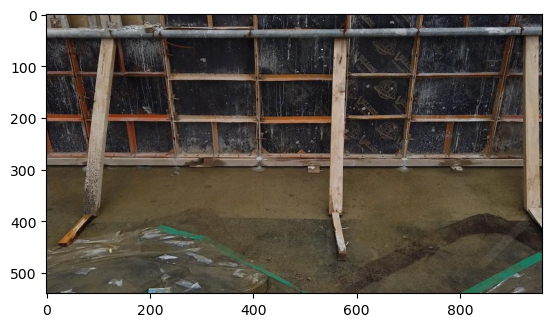

In [17]:
import matplotlib.pyplot as plt
img_name = files[key].split('.')[0] +".jpg"
img_color = plt.imread(root_path+"/"+img_name)
plt.imshow(img_color)
plt.show()

In [18]:
with open(os.path.join(root_path, files[become_right[0]]), 'r', encoding="UTF-8") as j:
    caption = json.load(j)
caption['outputs']
    

'<s> The image shows a construction site with a wall under construction. The wall appears to be made of concrete blocks, and there are wooden beams used as formwork to shape the wall. The formwork is designed to hold the concrete in place until it sets and can support its own weight.\n\nThe wooden beams are not being used as wedges to hold the formwork in place. Instead, they are being used to support the formwork and to provide stability to the wall as it is being built.\n\nThe wall is not yet finished, as evidenced by the exposed concrete blocks and the absence of a finished surface. The wooden beams are still in place, indicating that the wall is still in the process of being constructed.\n\nThe image does not show any form of bracing with a wooden wedge, as the wooden beams are not being used in that manner. The wooden beams are being used to support the formwork and the wall as it is being built.</s>'

### DPR

In [5]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import torch

In [6]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델과 토크나이저 로드
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base').to(device)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base').to(device)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')


# 규칙 문장 벡터화 함수
def encode_contexts(texts):
    inputs = context_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    embeddings = context_encoder(**inputs)
    return embeddings.pooler_output

# 쿼리 벡터화 함수
def encode_query(query):
    inputs = question_tokenizer(query, return_tensors="pt", padding=True, truncation=True).to(device)
    embeddings = question_encoder(**inputs)
    return embeddings.pooler_output



Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokeniz

In [7]:
def find_rank_of_answer_in_dpr_results(top_k_indices, answer_index):
    """
    top_k_indices: 상위 문서들의 인덱스가 담긴 배열
    answer_index: 찾고자 하는 정답 문서의 인덱스
    반환값: 정답 문서의 순위 (1부터 시작), 목록에 없는 경우 -1 반환
    """
    try:
        # top_k_indices 배열에서 정답 인덱스의 위치를 찾아 순위 반환
        rank = list(top_k_indices).index(answer_index) + 1
        return rank
    except ValueError:
        # 정답 인덱스가 배열에 없는 경우
        return -1

In [9]:
import torch
from transformers import LongformerTokenizer, LongformerModel
from tqdm import tqdm
import json
import os

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# BERT 모델과 토크나이저 로드
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')
model.to(device)  # 모델을 GPU로 이동
model.eval()

# 예시 함수 정의 (실제로는 적절한 방식으로 구현되어야 함)
def encode_contexts(rules):
    # 규칙을 벡터로 인코딩하는 함수 (예시)
    inputs = tokenizer(rules, padding=True, truncation=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력을 GPU로 이동
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 벡터 반환

def encode_query(query):
    # 쿼리를 벡터로 인코딩하는 함수 (예시)
    inputs = tokenizer(query, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력을 GPU로 이동
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 벡터 반환

def compute_similarity(query_embedding, doc_embedding):
    # 쿼리와 문서 간 유사도 계산 (예시)
    return torch.dot(query_embedding.flatten(), doc_embedding.flatten()).item()

def find_rank_of_answer_in_dpr_results(final_indices_mapped, answer_index):
    # 답변의 순위를 찾는 함수 (예시)
    try:
        return final_indices_mapped.index(answer_index) + 1
    except ValueError:
        return -1


# 규칙 문장 벡터화
context_embeddings = encode_contexts(combined_rules)

# top-K 리스트
list_k = [1, 5, 10, 15, 20, 25, 30, 50]
dpr_save_right_index = {}
dpr_save_wrong_index = {}

# 최종 top-K 평가
for final_top_k in list_k:
    correct = 0
    dpr_save_right_index[final_top_k] = {}
    dpr_save_wrong_index[final_top_k] = {}
    ind = 0
    
    for file in tqdm(files):
        # print(file)
        with open(os.path.join(root_path, file), 'r', encoding="UTF-8") as j:
            caption = json.load(j)
        query_embedding = encode_query(caption['outputs'])

        # 초기 유사성 계산 (상위 50개 추출)
        initial_top_k = 50
        initial_similarities = torch.matmul(query_embedding, context_embeddings.T).squeeze(0)
        initial_top_k_indices = torch.topk(initial_similarities, k=initial_top_k).indices

        # 초기 상위 50개 문서에 대해 re-ranking 수행
        re_ranked_rules = [combined_rules[i] for i in initial_top_k_indices]
        re_ranked_embeddings = encode_contexts(re_ranked_rules)

        # Re-ranked 유사성 계산 (상위 final_top_k 추출)
        re_ranked_similarities = torch.matmul(query_embedding, re_ranked_embeddings.T).squeeze(0)
        final_top_k_indices = torch.topk(re_ranked_similarities, k=final_top_k).indices

        # 최종 상위 final_top_k개의 인덱스를 초기 상위 50개의 인덱스로 매핑
        final_indices_mapped = [initial_top_k_indices[i].item() for i in final_top_k_indices]
        saved_final_indices_mapped = [(initial_top_k_indices[i].item(), re_ranked_similarities[i].item()) for i in final_top_k_indices]
        
        answer = file.split('_')[2]
        if answer[0] == 'Y':
            answer_index = int(answer[2:]) - 1
        elif answer[0] == 'N':
            answer_index = int(answer[2:]) + 49

        rank = find_rank_of_answer_in_dpr_results(final_indices_mapped, answer_index)

        if rank <= final_top_k and rank != -1:
            correct += 1
            dpr_save_right_index[final_top_k][ind] = saved_final_indices_mapped
        else:
            dpr_save_wrong_index[final_top_k][ind] = saved_final_indices_mapped

        ind += 1

    print(f"Top-{final_top_k} accuracy:", correct / len(files))


RuntimeError: CUDA out of memory. Tried to allocate 1.76 GiB (GPU 0; 9.78 GiB total capacity; 5.98 GiB already allocated; 1.37 GiB free; 7.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
import os
import shutil

# JSON 파일이 저장된 루트 경로
root_path = '/data1/sliver/jwsuh/construction_dataset/aihub/llava/llava_image_result_with_obj'
# 모든 파일 리스트 가져오기
files = [f for f in os.listdir(root_path)]

for file in files:
    # 파일명에서 키 추출
    key = file.split('_')[2]
    
    # 해당 키 이름의 폴더 경로 생성
    key_folder = os.path.join(root_path, key)
    if not os.path.exists(key_folder):
        os.makedirs(key_folder)
    
    # 파일을 해당 키 폴더로 이동
    source_file = os.path.join(root_path, file)
    destination_file = os.path.join(key_folder, file)
    shutil.copy(source_file, destination_file)


print("Files have been successfully moved to their respective folders.")


Files have been successfully moved to their respective folders.


In [31]:
# 규칙 문장 벡터화
context_embeddings = encode_contexts(combined_rules)

list_k = [1, 5, 10, 15, 20, 25, 30, 50]
dpr_save_right_index22 = {k: {} for k in list_k}
dpr_save_wrong_index22 = {k: {} for k in list_k}

idn = 0
for file in tqdm(files):
    with open(os.path.join(root_path, file), 'r', encoding="UTF-8") as j:
        caption = json.load(j)
    query_embedding = encode_query(caption['outputs'])

    # 초기 유사성 계산 (상위 50개 추출)
    initial_top_k = 50
    initial_similarities = torch.matmul(query_embedding, context_embeddings.T).squeeze(0)
    initial_top_k_indices = torch.topk(initial_similarities, k=initial_top_k).indices

    # 초기 상위 50개 문서에 대해 re-ranking 수행
    re_ranked_rules = [combined_rules[i] for i in initial_top_k_indices]
    re_ranked_embeddings = encode_contexts(re_ranked_rules)
    
    # Re-ranked 유사성 계산 (상위 50개 추출)
    re_ranked_similarities = torch.matmul(query_embedding, re_ranked_embeddings.T).squeeze(0)
    final_top_k_indices = torch.topk(re_ranked_similarities, k=initial_top_k).indices

    # 최종 상위 50개의 인덱스를 초기 상위 50개의 인덱스로 매핑
    saved_final_indices_mapped = [(initial_top_k_indices[i].item(), re_ranked_similarities[i].item()) for i in final_top_k_indices]
    final_indices_mapped = [initial_top_k_indices[i].item()for i in final_top_k_indices]
    answer = file.split('_')[2]
    if answer[0] == 'Y':
        answer_index = int(answer[2:]) - 1
    elif answer[0] == 'N':
        answer_index = int(answer[2:]) + 49

    for final_top_k in list_k:
        top_k_indices = final_indices_mapped[:final_top_k]
        rank = find_rank_of_answer_in_dpr_results(top_k_indices, answer_index)
        
        if rank <= final_top_k and rank != -1:
            if idn not in dpr_save_right_index22[final_top_k]:
                dpr_save_right_index22[final_top_k][idn] = []
            dpr_save_right_index22[final_top_k][idn].append(saved_final_indices_mapped)
        else:
            if idn not in dpr_save_wrong_index22[final_top_k]:
                dpr_save_wrong_index22[final_top_k][idn] = []
            dpr_save_wrong_index22[final_top_k][idn].append(saved_final_indices_mapped)

    idn += 1

for final_top_k in list_k:
    correct = len(dpr_save_right_index22[final_top_k])
    print(f"Top-{final_top_k} accuracy:", correct / len(files))


100%|██████████| 943/943 [20:45<00:00,  1.32s/it]

Top-1 accuracy: 0.06574761399787911
Top-5 accuracy: 0.2576882290562036
Top-10 accuracy: 0.39236479321314954
Top-15 accuracy: 0.4867444326617179
Top-20 accuracy: 0.5588547189819725
Top-25 accuracy: 0.6055143160127253
Top-30 accuracy: 0.6447507953340403
Top-50 accuracy: 0.8197242841993637
